### Imports

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from utils import add_Loss, clean_data

## Import and clean data 

In [7]:
#Select the dataset of one season of one year
YEAR = 2019
SEASON = "Rabi" # or "Kharif" 

#Path to the dataset
pathData = f"Data\RawDataUnified\RawData_{YEAR}_{SEASON}"
print(pathData)


df = pd.read_csv(pathData)

Data\RawDataUnified\RawData_2019_Rabi


In [8]:
#Clean an add loss to data
df=add_Loss(clean_data(df))
df

,Crop,Area Sown (Ha),Area Insured (Ha),SI Per Ha (Inr/Ha),Sum Insured (Inr),Indemnity Level,2002 Yield,2003 Yield,2004 Yield,2005 Yield,...,2010 Yield,2011 Yield,2012 Yield,2013 Yield,2014 Yield,2015 Yield,2016 Yield,2017 Yield,key,Loss
0,Bengal Gram (Chana),204.149503,77.473065,30000.0,7.277487e+06,0.8,2275.972276,4629.899829,4377.946588,4312.13996,...,760.00000,561.000000,816.000000,766.000000,670.000000,67.000000,202.000000,746.000000,andhra pradesh_anantapur_vidapanakal____,1.078638e+05
1,Bengal Gram (Chana),204.149503,77.473065,30000.0,7.277487e+06,0.8,2275.972276,4629.899829,4377.946588,4312.13996,...,944.00000,703.000000,842.000000,775.000000,647.000000,450.000000,627.000000,375.000000,andhra pradesh_anantapur_vajrakarur____,0.000000e+00
2,Bengal Gram (Chana),204.149503,77.473065,30000.0,7.277487e+06,0.8,2275.972276,4629.899829,4377.946588,4312.13996,...,752.00000,504.000000,1320.000000,1223.000000,688.000000,814.000000,379.000000,661.000000,andhra pradesh_anantapur_gooty____,1.516659e+06
3,Bengal Gram (Chana),204.149503,77.473065,30000.0,7.277487e+06,0.8,2275.972276,4629.899829,4377.946588,4312.13996,...,752.00000,504.000000,1320.000000,1223.000000,688.000000,814.000000,379.000000,661.000000,andhra pradesh_anantapur_guntakal____,1.516659e+06
4,Bengal Gram (Chana),204.149503,77.473065,30000.0,7.277487e+06,0.8,2275.972276,4629.899829,4377.946588,4312.13996,...,752.00000,504.000000,1320.000000,1223.000000,688.000000,814.000000,379.000000,661.000000,andhra pradesh_anantapur_pamidi____,1.516659e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317498,Wheat,204.149503,0.200000,56810.0,1.136200e+04,0.9,2275.972276,4629.899829,4377.946588,1582.98000,...,1987.31000,1417.770000,2804.980000,2382.030000,2518.480000,1362.950000,2469.040109,2766.065757,west bengal_howrah_uluberia-ii____,0.000000e+00
317499,Wheat,204.149503,0.750000,38557.0,2.891775e+04,0.9,2275.972276,4629.899829,4377.946588,2136.41000,...,2569.92000,2431.370000,2564.580000,2623.860000,2756.520000,2496.650000,2469.040109,2766.065757,west bengal_purba medinipur_haldia____,0.000000e+00
317500,Wheat,204.149503,0.750000,38557.0,2.891775e+04,0.9,2275.972276,4629.899829,4377.946588,2136.41000,...,2569.92000,2431.370000,2564.580000,2623.860000,2756.520000,2496.650000,2469.040109,2766.065757,west bengal_purba medinipur_mohisadal-ii____,0.000000e+00
317501,Maize,204.149503,24.520000,34580.0,8.479016e+05,0.9,2275.972276,4629.899829,4377.946588,2556.00000,...,2950.00000,2968.000000,2975.000000,3800.000000,2260.000000,3030.000000,2469.040109,2766.065757,west bengal_paschim medinipur______,9.387161e+03


## UMAP embeding

In [9]:
import umap
from sklearn.preprocessing import PowerTransformer
import warnings
warnings.filterwarnings("ignore")

df_with_key=df.copy()
df = df.drop(columns = ["key"])

# #Preprocessing numerical
numerical = df.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = df.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(df.select_dtypes(include='object').columns) / df.shape[1]

In [10]:
# from umap import UMAP

fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

In [11]:
import umap.umap_ as uu

# #Augmenting the numerical embedding with categorical
intersection = uu.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = uu.reset_local_connectivity(intersection)
embedding = uu.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False, densmap_kwds="Salut", output_dens=False)

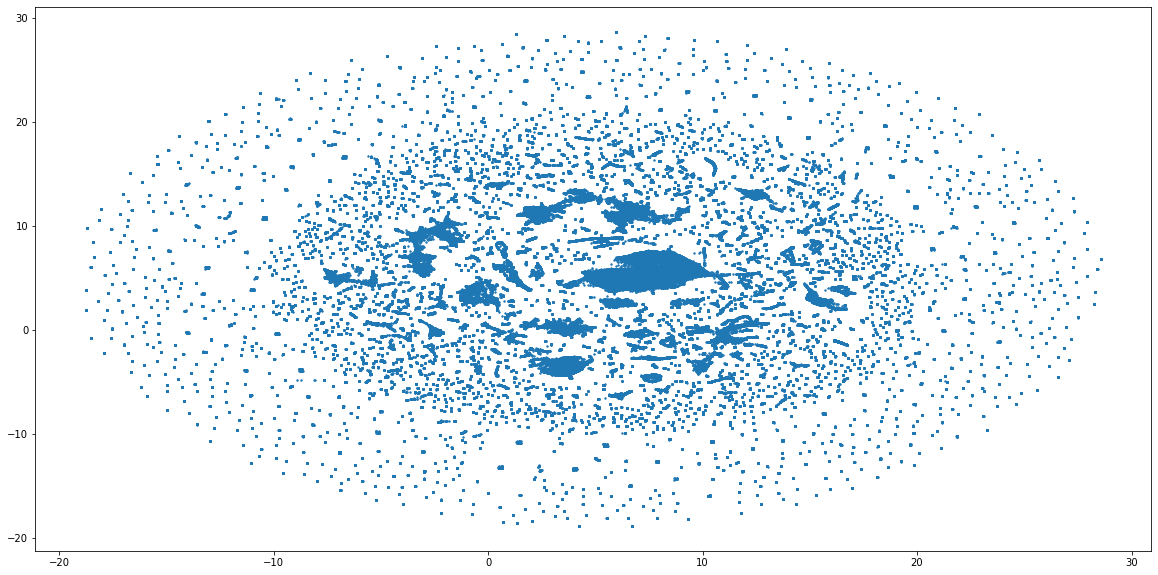

In [12]:
plt.figure(figsize=(20, 10))
plt.scatter(*embedding[0].T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

## K-Prototypes

In [20]:
# full_data=df.copy(deep=True)
# import kmodes
# from kmodes.kprototypes import KPrototypes

In [21]:
# kprot_data = full_data.copy()
# #Pre-processing
# for c in full_data.select_dtypes(exclude='object').columns:
#     pt = PowerTransformer()
#     kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

# categorical_columns = [1,2,3] #make sure to specify correct indices

# #Actual clustering
# kproto = KPrototypes(n_clusters= 15, init='Cao', n_jobs = 4)
# clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

# #long à tourner : environ 8 min

In [22]:
# #Prints the count of each cluster group
# pd.Series(clusters).value_counts()

13    2984
2     2804
4     1988
11    1925
12    1757
3     1675
8     1526
14    1026
5      975
1      966
7      341
10     268
9      235
6      166
0       99
dtype: int64

In [23]:
# #OPTIONAL: Elbow plot with cost (will take a LONG time)
# costs = []
# n_clusters = []
# clusters_assigned = []

# for i in tqdm(range(2, 25)):
#     try:
#         kproto = KPrototypes(n_clusters= i, init='Cao', verbose=2)
#         clusters = kproto.fit_predict(kprot_data, categorical=[0, 6, 7, 9, 13])
#         costs.append(kproto.cost_)
#         n_clusters.append(i)
#         clusters_assigned.append(clusters)
#     except:
#         print(f"Can't cluster with {i} clusters")
        
# fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))
# fig.show()

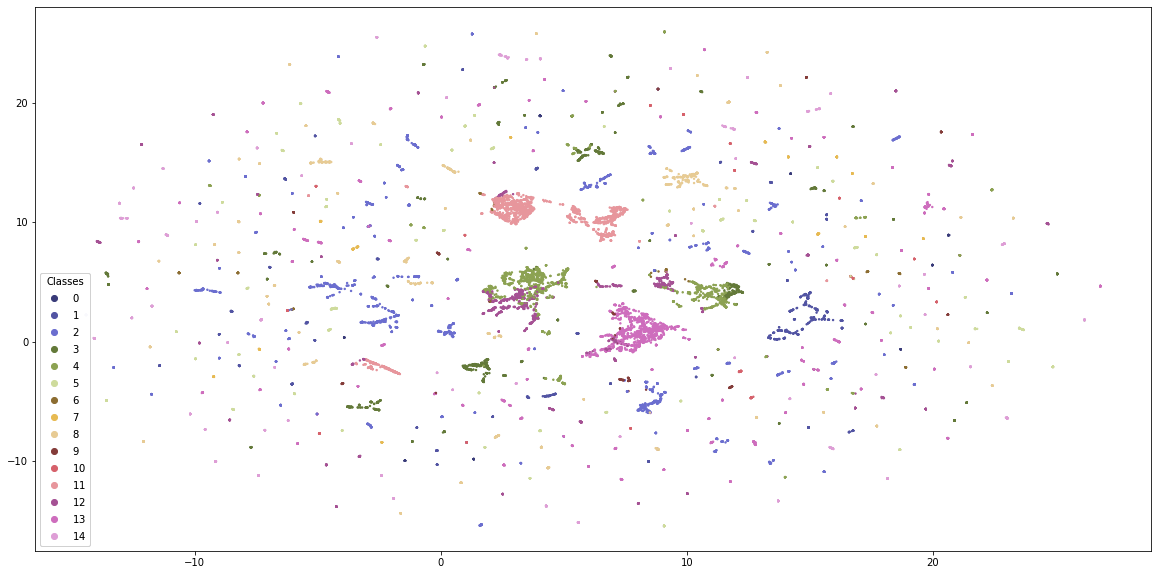

In [24]:
# fig, ax = plt.subplots()
# fig.set_size_inches((20, 10))
# embedding=embedding[0]
# scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=clusters, cmap='tab20b', alpha=1.0)

# # produce a legend with the unique colors from the scatter
# legend1 = ax.legend(*scatter.legend_elements(num=15),
#                     loc="lower left", title="Classes")
# ax.add_artist(legend1)

## K-means (for mixed data)

In [13]:
from sklearn.cluster import KMeans
full_data=df.copy(deep=True)

In [17]:
#One-Hot-Encoding
data = pd.get_dummies(full_data)

#Pre-processing
for c in data.columns:
    pt = PowerTransformer()
    data.loc[:, c] = pt.fit_transform(np.array(data[c]).reshape(-1, 1))

#Actual Clustering
kmeans = KMeans(n_clusters=10).fit(data)
kmeans_labels = kmeans.labels_

In [46]:
# #OPTIONAL: Elbow plot with inertia
# #Elbow method to choose the optimal number of clusters
# sse = {}
# for k in tqdm(range(2, 50)):
#     kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
#     sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
# fig = go.Figure(data=go.Scatter(x=list(sse.keys()), y=list(sse.values())))
# fig.show()

In [20]:
embedding.dtype
np.save("embedding",embedding)



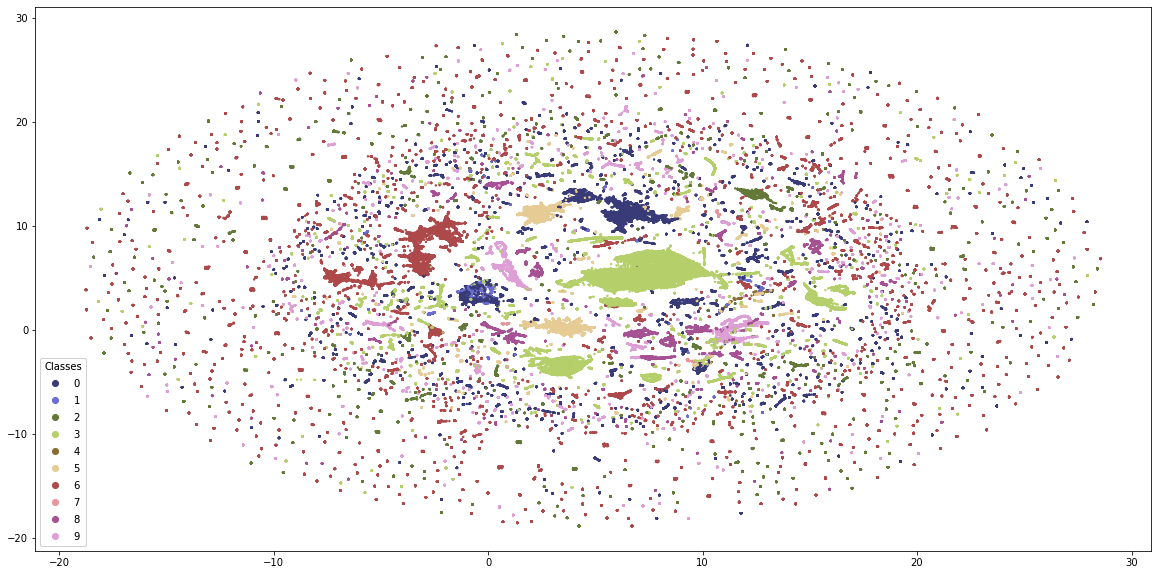

In [25]:
# embedding=embedding[0] #because tuple #comment if load embedding
embedding = np.load("Outputs/embedding_Rabi.npy")

fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=kmeans_labels, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=10),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

## Implémentation critère cluster

2.1171544533934035
2.043593446117891
2.2951566733481417
1.8876108125150748
2.0025663314017264
1.8847462609441614
2.2520353732683493
2.0752898646620435
2.5163502358783276
1.6490062345337468


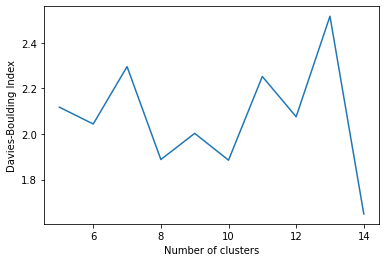

In [24]:
from sklearn.metrics import davies_bouldin_score


results = {}

for i in range(5,15):
    kmeans = KMeans(n_clusters=i, random_state=30).fit(data)
    labels = kmeans.labels_
    db_index = davies_bouldin_score(data, labels)
    print(db_index)
    results.update({i: db_index})


plt.plot(list(results.keys()), list(results.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Boulding Index")
plt.show()